In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import requests
import io

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none' 
matplotlib.rc('font', family='Arial') 
matplotlib.rc('font', serif='Helvetica Neue')
from matplotlib import pyplot as plt

In [2]:
import seaborn as sns

In [3]:
SAVE_FIGS = False

In [4]:
# Grab our unit test alignment
example_diamond_r = requests.get("https://raw.githubusercontent.com/FredHutch/FAMLI/master/tests/example.diamond.aln?token=APpZcToVBHrT_nhgMjNDEMXwbqoXHQ08ks5ay-9vwA%3D%3D")
example_diamond_h = io.StringIO(example_diamond_r.text)
test_aln = pd.read_csv(example_diamond_h, 
                       sep='\t',
                      header=None,
                      index_col=None,
                      names=[
                          'qseqid',
                          'sseqid',
                          'pident',
                          'length',
                          'mismatch',
                          'gapopen',
                          'qstart',
                          'qend',
                          'sstart',
                          'send',
                          'evalue',
                          'bitscore',
                          'qlen',
                          'slen',
                        ])

In [5]:
test_aln.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
0,NC_000913.3:3397755-3398408-80,UniRef100_UPI0002CAFAA7,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
1,NC_000913.3:3397755-3398408-80,UniRef100_UPI0005C5CD60,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
2,NC_000913.3:3397755-3398408-80,UniRef100_UPI0002A1C0E2,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
3,NC_000913.3:3397755-3398408-80,UniRef100_UPI00045BAB96,100.0,49,0,0,3,149,69,117,7.000000e-23,98.2,150,190
4,NC_000913.3:3397755-3398408-80,UniRef100_UPI0004540DAB,100.0,49,0,0,3,149,70,118,7.000000e-23,98.2,150,189


In [6]:
print(len(test_aln))

100468


In [7]:
print("Our alignment here includes all subjects within {:0.0f} percent of the best possible percent identity.".format(
    (test_aln.groupby('qseqid').max().pident - test_aln.groupby('qseqid').min().pident).max()
))

Our alignment here includes all subjects within 11 percent of the best possible percent identity.


In [8]:
# Only looking at alignments as good as the best alignments (Top hits)
best_hits_per_query = [
    len(q_block[q_block.pident == q_block.pident.max()])
    for query, q_block in test_aln.groupby('qseqid')
]


In [9]:
print("There are a total of {} alignments equally well scored to the {} queries".format(
    np.sum(best_hits_per_query),
    len(test_aln.qseqid.unique())    
))
print("There are an average of {:0.0f} (median {:0.0f}, min {}, and max {}) subjects tied with the best hit per query.".format(
    np.mean(best_hits_per_query),
    np.median(best_hits_per_query),
    np.min(best_hits_per_query),
    np.max(best_hits_per_query),
))

There are a total of 57983 alignments equally well scored to the 360 queries
There are an average of 161 (median 165, min 1, and max 384) subjects tied with the best hit per query.


In [10]:
# Print out some aggregate stats. This shows how bad the problem is. There are only three TRUE positive subjects
# Group by query (read) and count up how many unique queries to which each read aligns:
subjects_per_query = test_aln.groupby('qseqid').count().sseqid

print("There are {} subjects and {} queries".format(
    len(test_aln.sseqid.unique()),
    len(test_aln.qseqid.unique()),
))
print("Queries (reads) have a mean of {:0.0f}, median {:0.0f}, min {}, and max {} aligning subjects (references).".format(
    subjects_per_query.mean(),
    subjects_per_query.median(),
    subjects_per_query.min(),
    subjects_per_query.max(),
))


There are 1171 subjects and 360 queries
Queries (reads) have a mean of 279, median 268, min 77, and max 537 aligning subjects (references).


<Figure size 432x288 with 0 Axes>

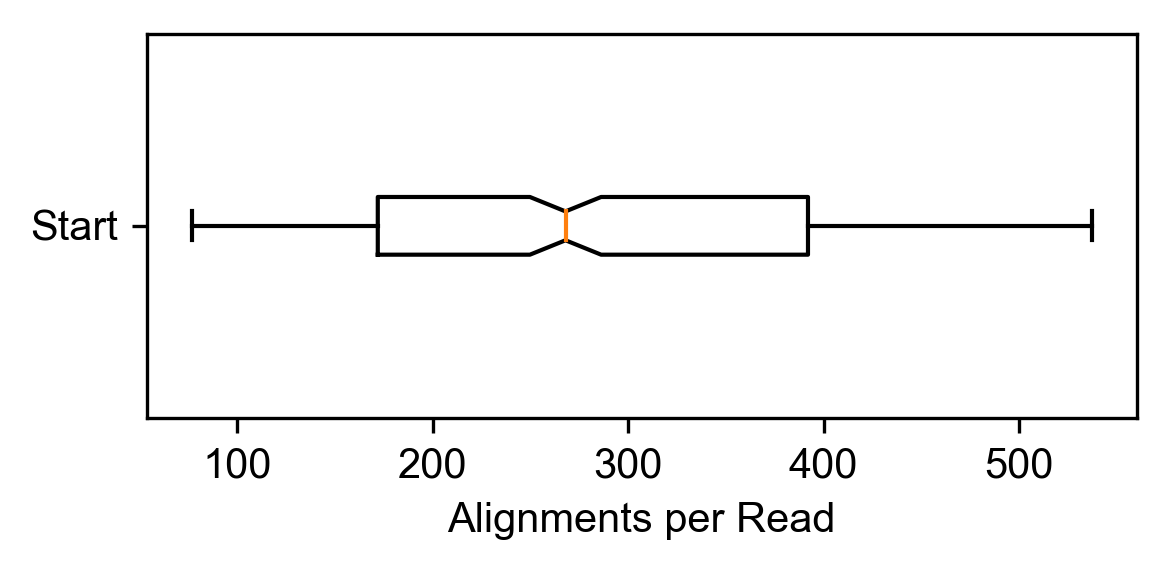

In [11]:
plt.clf()
plt.figure(figsize=(4,2), dpi=300)
plt.boxplot(
    subjects_per_query, 
    labels=['Start'],
    vert=False,
    notch=True,
)
plt.xlabel('Alignments per Read')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/AlnPerRead___start.svg')
plt.show()


In [12]:
spq = subjects_per_query.to_frame('Start')
spq.head()

,Start
qseqid,
NC_000913.3:102203-103183-1,289
NC_000913.3:102203-103183-10,268
NC_000913.3:102203-103183-100,416
NC_000913.3:102203-103183-101,274
NC_000913.3:102203-103183-102,265


<Figure size 432x288 with 0 Axes>

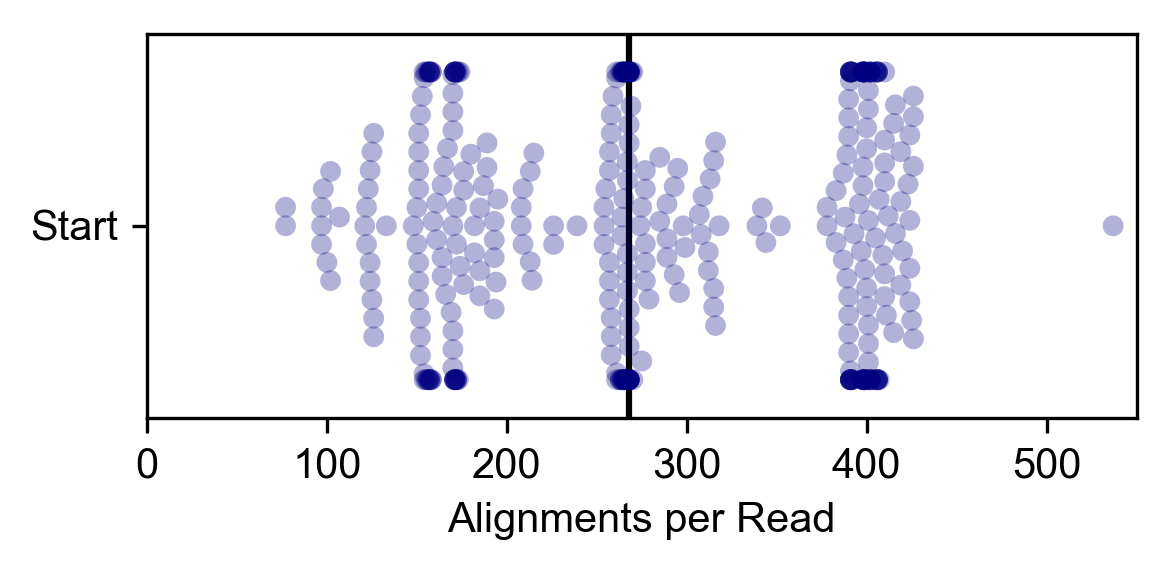

In [13]:
plt.clf()
plt.figure(figsize=(4,2), dpi=300)
ax = plt.gca()
sns.swarmplot(
    data=spq.melt(),
    x='value',
    y='variable',
    ax=ax,
    alpha=0.3,
    color='navy'
)
ax.axvline(
    x=spq.Start.median(),
    color='k'
)
ax.set_ylabel("")
ax.set_xlabel('Alignments per Read')
ax.set_xlim([0,550])

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/AlnPerRead___start_swarm.svg', dpi=300)
plt.show()

In [14]:
# Make coverage-o-grams for each subject (reference)
subject_coverage = {}
for subj, s_block in test_aln.groupby('sseqid'):
    s_coverage = np.zeros(s_block.iloc[0].slen, dtype='int')
    for idx, q in s_block.iterrows():
        s_start = min([q.sstart-1, q.send])
        s_end = max([q.sstart-1, q.send])
        s_coverage[s_start:s_end] += 1
    subject_coverage[subj] = s_coverage


<Figure size 432x288 with 0 Axes>

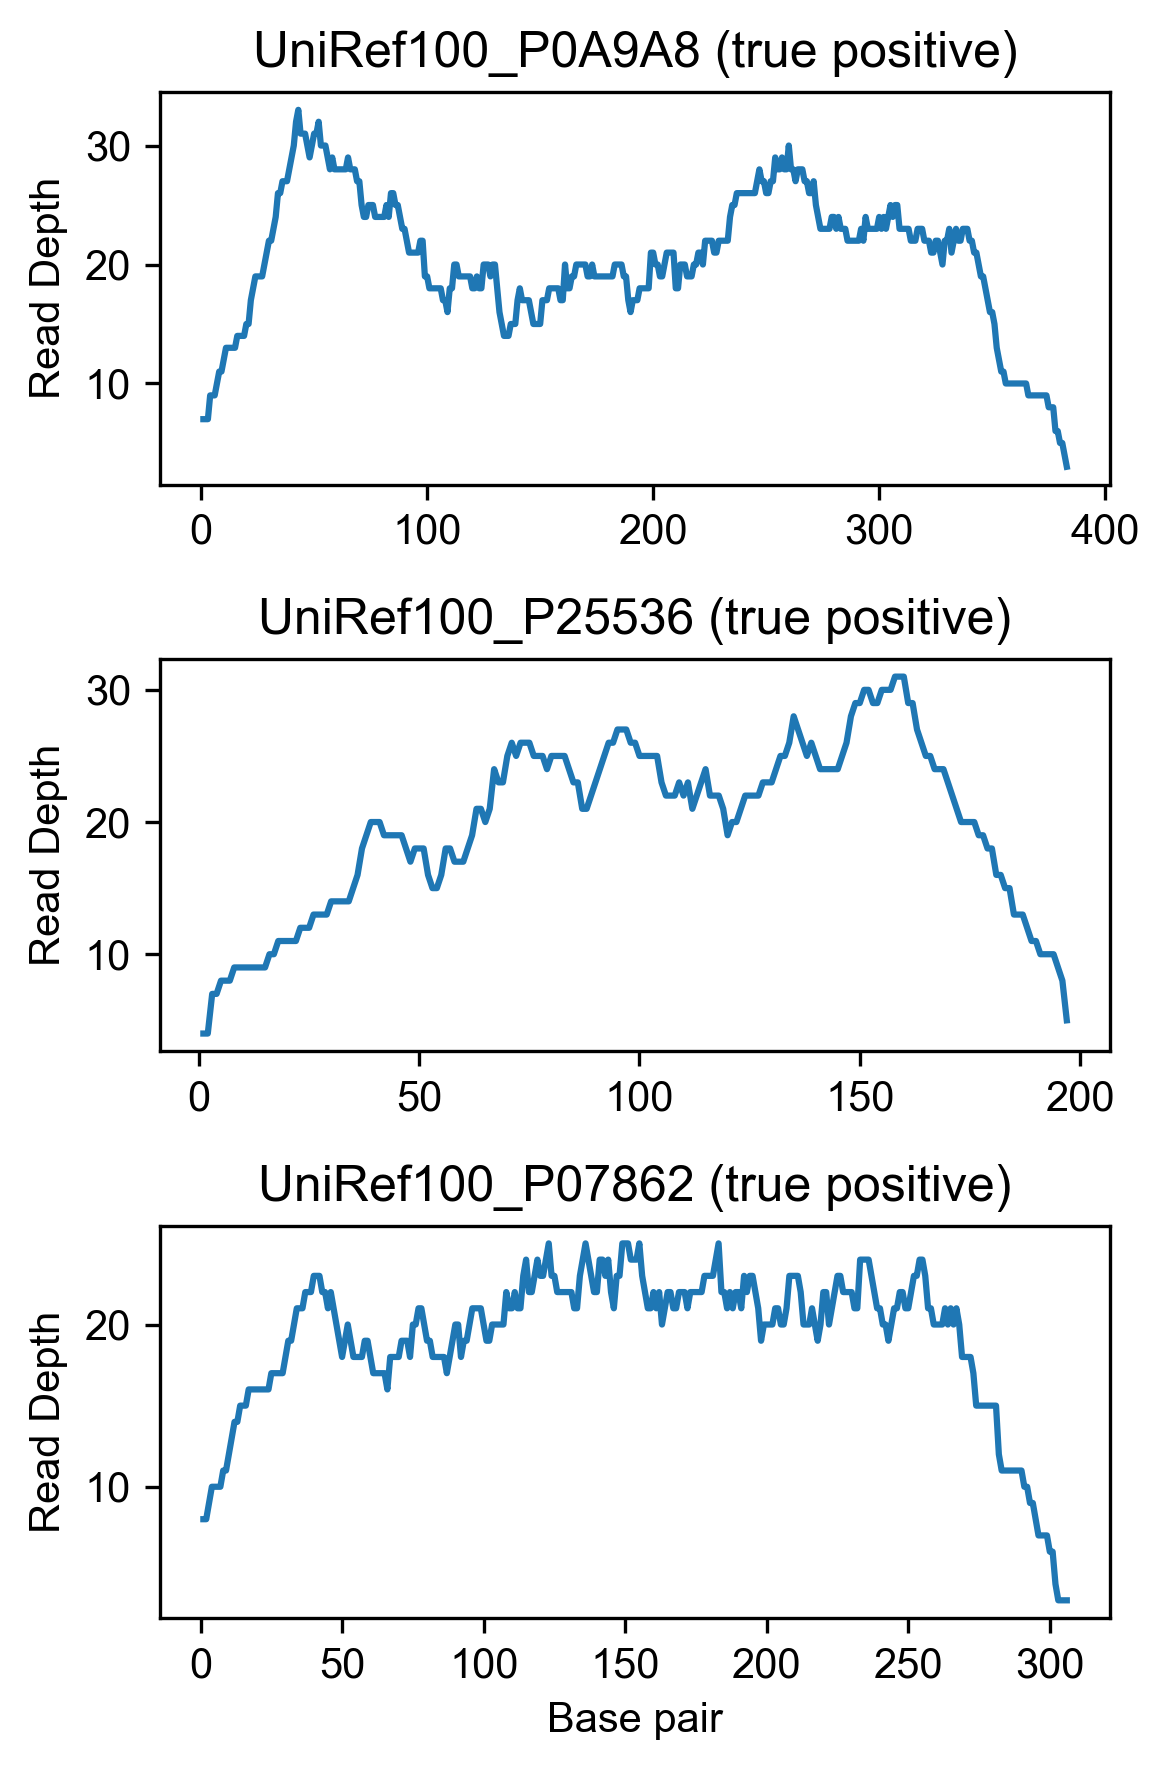

In [15]:
# True positives (references actually in our sample):
# UniRef100_P0A9A8
# UniRef100_P25536
# UniRef100_P07862

subj_true_positives = [
    'UniRef100_P0A9A8',
    'UniRef100_P25536',
    'UniRef100_P07862'
]

# Let us make some coverage-o-grams for these
plt.clf()
fig = plt.figure(figsize=(4,6), dpi=300)

UniRef100_P0A9A8_subplot = plt.subplot(311)
enumerated_vector = [(i+1, c) for i, c in enumerate(subject_coverage['UniRef100_P0A9A8'])]
UniRef100_P0A9A8_subplot.plot(
    [i[0] for i in enumerated_vector], 
    [i[1] for i in enumerated_vector], 
)
UniRef100_P0A9A8_subplot.set_title('UniRef100_P0A9A8 (true positive)')
UniRef100_P0A9A8_subplot.set_ylabel('Read Depth')

UniRef100_P25536_subplot = plt.subplot(312)
enumerated_vector = [(i+1, c) for i, c in enumerate(subject_coverage['UniRef100_P25536'])]
UniRef100_P25536_subplot.plot(
    [i[0] for i in enumerated_vector], 
    [i[1] for i in enumerated_vector], 
)
UniRef100_P25536_subplot.set_title('UniRef100_P25536 (true positive)')
UniRef100_P25536_subplot.set_ylabel('Read Depth')


UniRef100_P07862_subplot = plt.subplot(313)
enumerated_vector = [(i+1, c) for i, c in enumerate(subject_coverage['UniRef100_P07862'])]
UniRef100_P07862_subplot.plot(
    [i[0] for i in enumerated_vector], 
    [i[1] for i in enumerated_vector], 
)
UniRef100_P07862_subplot.set_title('UniRef100_P07862 (true positive)')
UniRef100_P07862_subplot.set_ylabel('Read Depth')
UniRef100_P07862_subplot.set_xlabel('Base pair')

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/Coverage__TruePos.svg')
plt.show()

In [16]:
# Calculate the coverage evenness, trimming the 5' and 3' ends 
# (as due to alignment being short at the ends of the subjects there is a natural tail off)
TRIM_5 = 18
TRIM_3 = 18
subject_coverage_evenness = [
    (subject, subject_coverage[subject][TRIM_5:-TRIM_3].std() / subject_coverage[subject][TRIM_5:-TRIM_3].mean())
    for subject in subject_coverage
]

subject_coverage_evenness.sort(key=lambda p: p[1])


In [17]:
# Here is where we filter based on our standard dev / mean coverage depth. 
# We use this as a metric of evenness of coverage. 
# It is highly likely that refs with very uneven coverage are falsely positive. 

STD_MEAN_CUTOFF = 1.0
# Our actual filtering steps
subjects_even_pass = {p[0] for p in subject_coverage_evenness if p[1] <= STD_MEAN_CUTOFF}
subjects_even_fail = {p[0] for p in subject_coverage_evenness if p[1] > STD_MEAN_CUTOFF}
print(len(subjects_even_pass))

908


<Figure size 432x288 with 0 Axes>

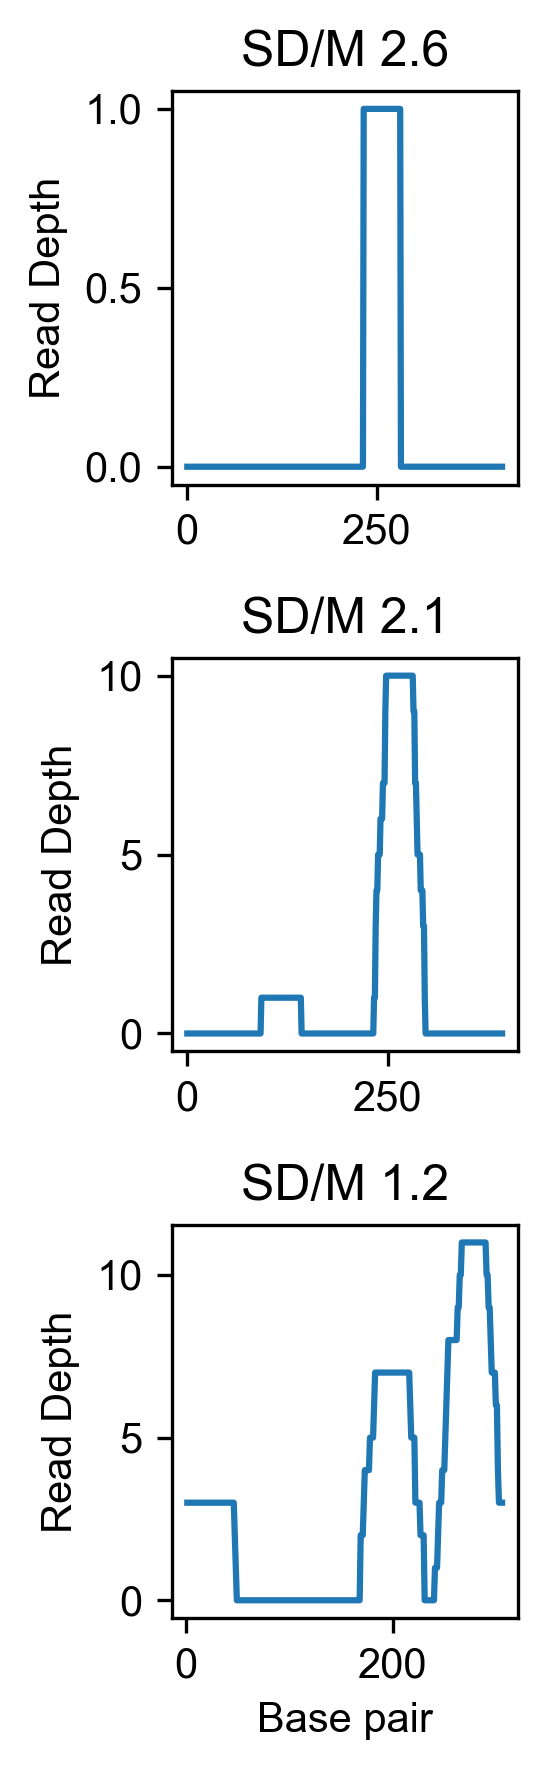

In [18]:
# Let's look at the coverage-o-grams of some of the highly uneven references (all of which are not present)

plt.clf()
fig = plt.figure(figsize=(2,6), dpi=300)

subplot1 = plt.subplot(311)
enumerated_vector_1 = [(i+1, c) for i, c in enumerate(subject_coverage[subject_coverage_evenness[-1][0]])]
subplot1.plot(
    [i[0] for i in enumerated_vector_1], 
    [i[1] for i in enumerated_vector_1], 
)
subplot1.set_title('SD/M {:0.1f}'.format(
    subject_coverage_evenness[-1][1],
))
subplot1.set_ylabel('Read Depth')

subplot2 = plt.subplot(312)
enumerated_vector_2 = [(i+1, c) for i, c in enumerate(subject_coverage[subject_coverage_evenness[-150][0]])]
subplot2.plot(
    [i[0] for i in enumerated_vector_2], 
    [i[1] for i in enumerated_vector_2], 
)
subplot2.set_title('SD/M {:0.1f}'.format(
    subject_coverage_evenness[-150][1],
))
subplot2.set_ylabel('Read Depth')

subplot3 = plt.subplot(313)
enumerated_vector_3 = [(i+1, c) for i, c in enumerate(subject_coverage[subject_coverage_evenness[-200][0]])]
subplot3.plot(
    [i[0] for i in enumerated_vector_3], 
    [i[1] for i in enumerated_vector_3], 
)
subplot3.set_title('SD/M {:0.1f}'.format(
    subject_coverage_evenness[-200][1],
))
subplot3.set_ylabel('Read Depth')


subplot3.set_xlabel('Base pair')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/Coverage__TrueNeg.svg')
plt.show()


In [19]:
# Find some of our false positives that pass our eveness filter
subjects_even_pass_fp = subjects_even_pass - set(subj_true_positives)
print(len(subjects_even_pass_fp))

905


In [20]:
false_pos_evenness = [p for p in subject_coverage_evenness if p[0] in subjects_even_pass_fp]

<Figure size 432x288 with 0 Axes>

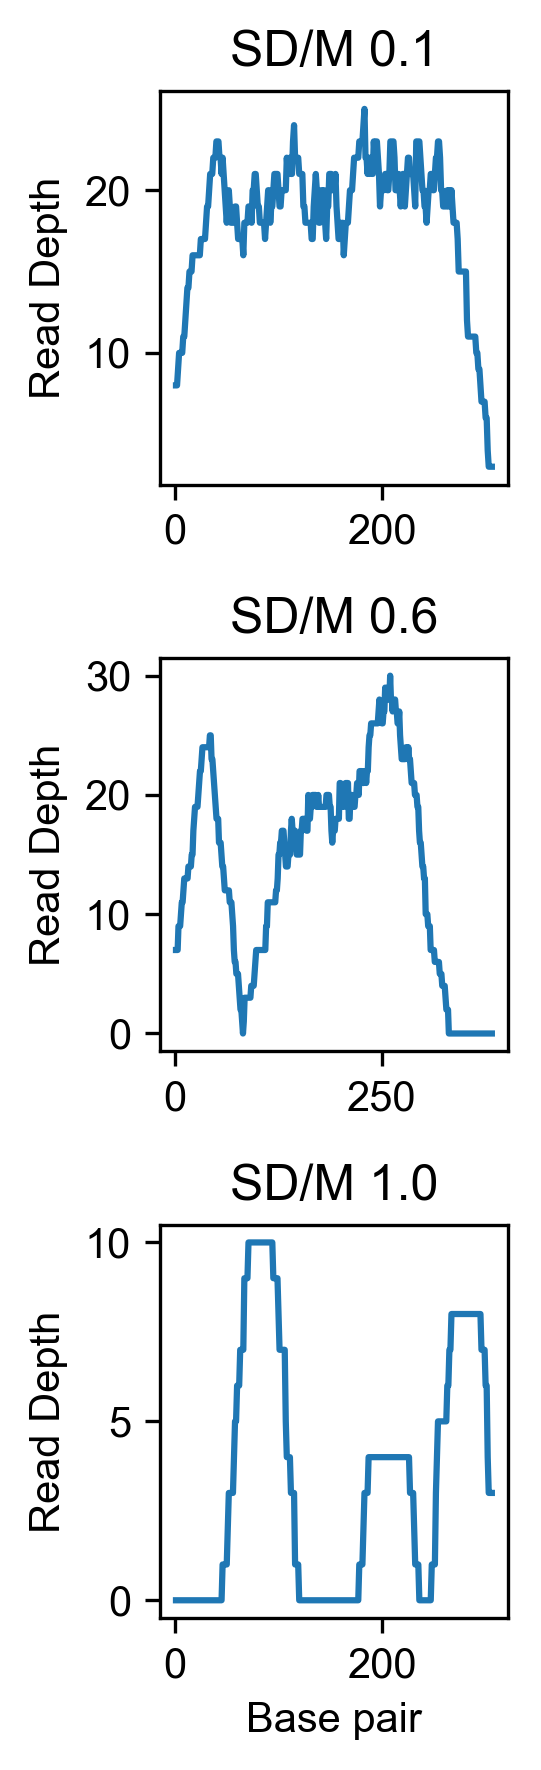

In [21]:
# Let's look at the coverage-o-grams of some of the false positives that pass the evenness filter

plt.clf()
fig = plt.figure(figsize=(2,6), dpi=300)

subplot1 = plt.subplot(311)
enumerated_vector_1 = [(i+1, c) for i, c in enumerate(subject_coverage[false_pos_evenness[0][0]])]
subplot1.plot(
    [i[0] for i in enumerated_vector_1], 
    [i[1] for i in enumerated_vector_1], 
)
subplot1.set_title('SD/M {:0.1f}'.format(
    false_pos_evenness[0][1],
))
subplot1.set_ylabel('Read Depth')

subplot2 = plt.subplot(312)
enumerated_vector_2 = [(i+1, c) for i, c in enumerate(subject_coverage[false_pos_evenness[-200][0]])]
subplot2.plot(
    [i[0] for i in enumerated_vector_2], 
    [i[1] for i in enumerated_vector_2], 
)
subplot2.set_title('SD/M {:0.1f}'.format(
    false_pos_evenness[-200][1],
))
subplot2.set_ylabel('Read Depth')

subplot3 = plt.subplot(313)
enumerated_vector_3 = [(i+1, c) for i, c in enumerate(subject_coverage[false_pos_evenness[-1][0]])]
subplot3.plot(
    [i[0] for i in enumerated_vector_3], 
    [i[1] for i in enumerated_vector_3], 
)
subplot3.set_title('SD/M {:0.1f}'.format(
    false_pos_evenness[-1][1],
))
subplot3.set_ylabel('Read Depth')


subplot3.set_xlabel('Base pair')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/Coverage__FalsePos.svg')
plt.show()



In [22]:
# Filter out the alignments from subjects (references) that failed our evenness filter
test_aln_ef = test_aln[test_aln.sseqid.apply(lambda sid: sid in subjects_even_pass)]
test_aln_ef.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
0,NC_000913.3:3397755-3398408-80,UniRef100_UPI0002CAFAA7,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
1,NC_000913.3:3397755-3398408-80,UniRef100_UPI0005C5CD60,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
2,NC_000913.3:3397755-3398408-80,UniRef100_UPI0002A1C0E2,100.0,49,0,0,3,149,71,119,7.000000e-23,98.2,150,197
3,NC_000913.3:3397755-3398408-80,UniRef100_UPI00045BAB96,100.0,49,0,0,3,149,69,117,7.000000e-23,98.2,150,190
4,NC_000913.3:3397755-3398408-80,UniRef100_UPI0004540DAB,100.0,49,0,0,3,149,70,118,7.000000e-23,98.2,150,189


There are 908 subjects and 360 queries that passed the first evenness filter
Now queries (reads) have a mean of 271, median 267, min 77, and max 398 aligning subjects (references).


<Figure size 432x288 with 0 Axes>

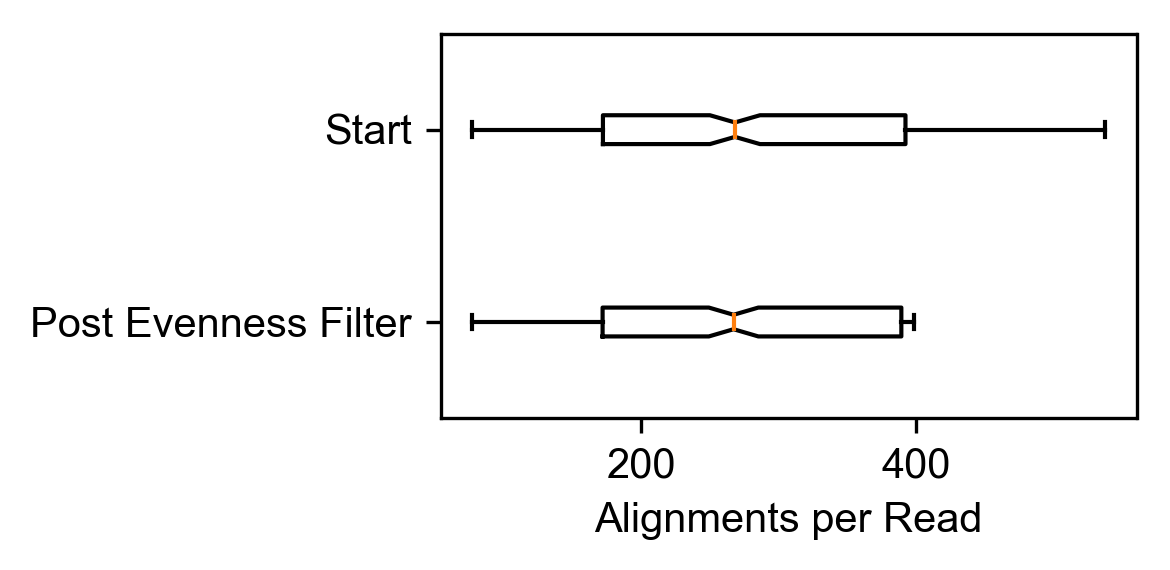

In [23]:
# Print out some aggregate stats After filtering. 
# This shows how bad the problem is. There are only three TRUE positive subjects
# Group by query (read) and count up how many unique queries to which each read aligns:
subjects_per_query_ef = test_aln_ef.groupby('qseqid').count().sseqid

print("There are {} subjects and {} queries that passed the first evenness filter".format(
    len(test_aln_ef.sseqid.unique()),
    len(test_aln_ef.qseqid.unique()),
))

print("Now queries (reads) have a mean of {:0.0f}, median {:0.0f}, min {}, and max {} aligning subjects (references).".format(
    subjects_per_query_ef.mean(),
    subjects_per_query_ef.median(),
    subjects_per_query_ef.min(),
    subjects_per_query_ef.max(),
))
plt.clf()
plt.figure(figsize=(4,2), dpi=300)
plt.boxplot(
    [
        subjects_per_query_ef,
        subjects_per_query,
    ], 
    labels=[
        'Post Evenness Filter',
        'Start'
    ],
    vert=False,
    notch=True,
)
plt.xlabel('Alignments per Read')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/AlnPerRead___postef.svg')
plt.show()




In [24]:
spq['Evenness Filter'] = subjects_per_query_ef

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

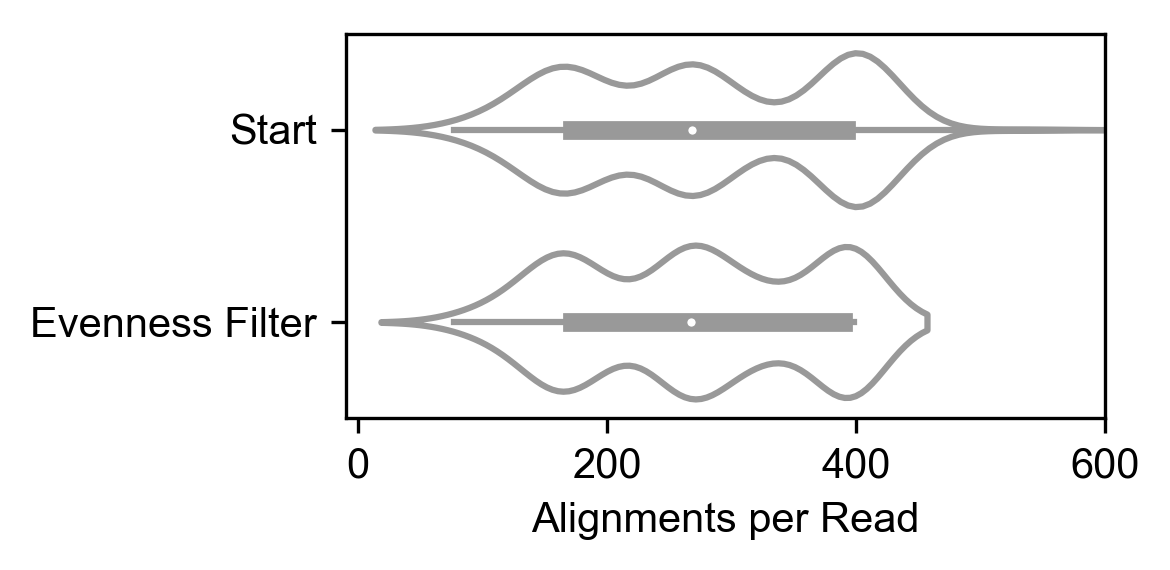

In [25]:
plt.clf()
plt.figure(figsize=(4,2), dpi=300)
ax = plt.gca()
sns.violinplot(
    data=spq[[
        'Start',
        'Evenness Filter'
    ]].melt(),
    x='value',
    y='variable',
    ax=ax,
    alpha=0.3,
    color='white',
    scale='count'
)
"""ax.axvline(
    x=spq.Start.median(),
    color='k',
    ymin=0.6,
    ymax=0.9
)
ax.axvline(
    x=spq['Post Evenness Filter'].median(),
    color='k',
    ymin=0.1,
    ymax=0.4
)
"""

ax.set_ylabel("")
ax.set_xlabel('Alignments per Read')
ax.set_xlim([-10,600])

plt.tight_layout()
#if SAVE_FIGS:
#    plt.savefig('figures/AlnPerRead___PEF_swarm.svg', dpi=300)
plt.show()

In [26]:
# Pick a few random queries to plot
example_queries = list(np.random.choice(test_aln_ef.qseqid, replace=False, size=3))

In [27]:
# Dict comprehension to get our subject lengths easily
s_len = {r.sseqid: r.slen for idx, r in test_aln_ef.iterrows()}

In [28]:
# Now we are into the iterative portion of our algorith. We will use a few data structures to ease this approach
# Nested dicts to store our initialized likelihood given alignment
likelihood_q_s = defaultdict(dict)
likelihood_s_q = defaultdict(dict)
# Nested dict for the sstart and send as a tuple
coverage_s_q   = defaultdict(dict)



In [29]:
# Grab our bitscores to initialize our likelihoods per alignment normalized to 1.0 per query
# Also cache the per-subject coverage
for query, q_block in test_aln_ef.groupby('qseqid'):
    q_bitscore_sum = q_block.bitscore.sum()
    for idx, row in q_block.iterrows():
        likelihood_q_s[query][row.sseqid] = row.bitscore / q_bitscore_sum 
        likelihood_s_q[row.sseqid][query] = row.bitscore / q_bitscore_sum 
        coverage_s_q[row.sseqid][query]=(min([row.sstart,row.send]), max([row.sstart,row.send]))
      



Iteration 1
NC_000913.3:102203-103183-31
0.003622644861435608 0.00047496539441370427
There are 908 subjects and 360 queries to consider
Removing 48122 unlikely alignments
Iteration 2
NC_000913.3:102203-103183-31
0.0042448246365561215 0.0022305870974305693
There are 908 subjects and 360 queries to consider
Removing 5831 unlikely alignments
Iteration 3
NC_000913.3:102203-103183-31
0.004548677180796224 0.0029233761427723535
There are 908 subjects and 360 queries to consider
Removing 7781 unlikely alignments
Iteration 4
NC_000913.3:102203-103183-31
0.005705134859030912 0.0031832171057769357
There are 908 subjects and 360 queries to consider
Removing 8282 unlikely alignments
Iteration 5
NC_000913.3:102203-103183-31
0.007855956331403137 0.002935962699291178
There are 908 subjects and 360 queries to consider
Removing 12095 unlikely alignments
Iteration 6
NC_000913.3:102203-103183-31
0.017134240457767645 0.009583513770279838
There are 908 subjects and 360 queries to consider
Removing 12255 unl

<Figure size 432x288 with 0 Axes>

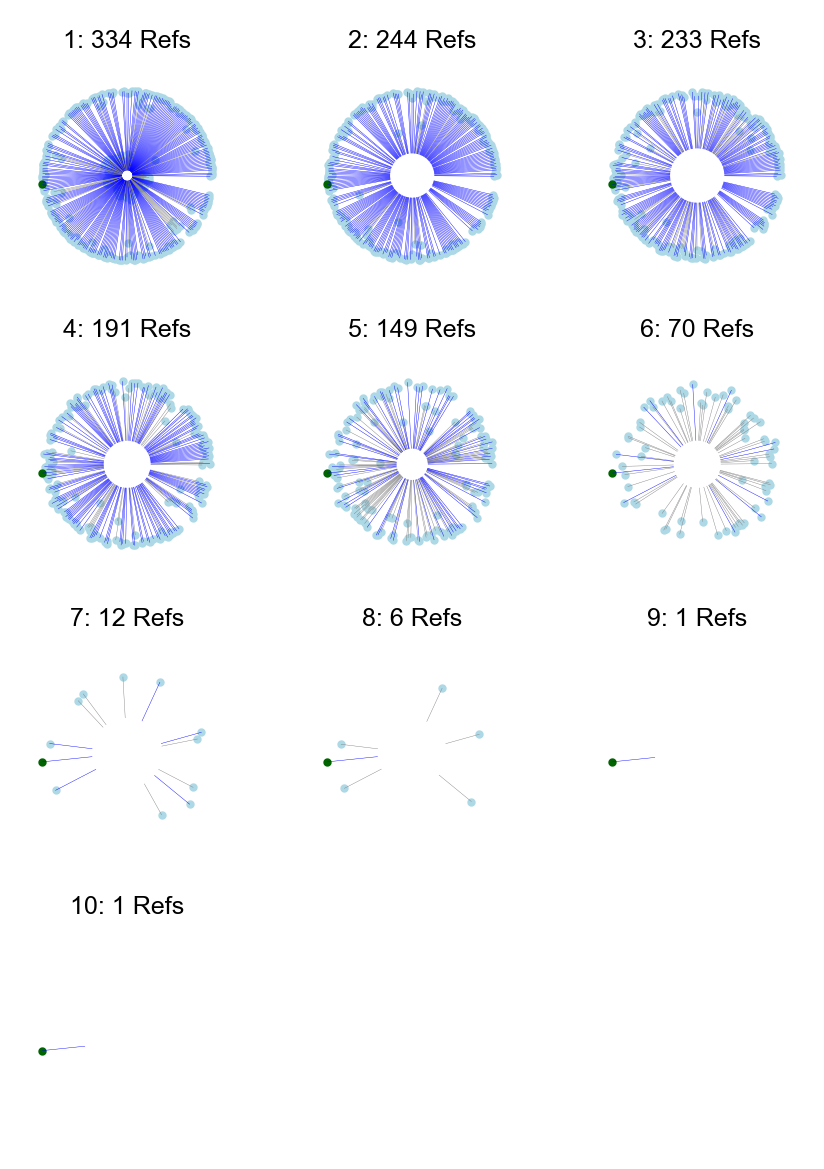

In [30]:
MAX_ITERATIONS = 20
SCALE = 0.9
culled=True
iteration = 0
plt.clf()
fig = plt.figure(figsize=(3,4), dpi=300, facecolor='white')

while culled and iteration <= MAX_ITERATIONS:
    iteration+=1
    print("Iteration {}".format(iteration))
    
    # recalculate the s_total_weight based on prior iteration likelihoods

    s_total_weight = {
        s: sum(likelihood_s_q[s].values())
        for s in likelihood_s_q
    }
    
    # Recalculate our weights 
    weight_s_q = defaultdict(dict)
    weight_q_s = defaultdict(dict)
    for subject in likelihood_s_q:
        for query in likelihood_s_q[subject]:
            weight_s_q[subject][query] = likelihood_s_q[subject][query] * s_total_weight[subject] 
            weight_q_s[query][subject] = likelihood_s_q[subject][query] * s_total_weight[subject] 
    
    # Get the total weight per query
    q_total_weight = {
        q: sum(weight_q_s[q].values())
        for q in weight_q_s
    }
    
    # Recalculate our likelihoods using the weights
    for subject in weight_s_q:
        for query in weight_s_q[subject]:
            likelihood_s_q[subject][query] = weight_s_q[subject][query] / q_total_weight[query]
            likelihood_q_s[query][subject] = weight_s_q[subject][query] / q_total_weight[query]
        
    # Do a bit of plotting for iteration 

    query = example_queries[0]
    #query = 'NC_000913.3:105275-106486-158'
    #query='NC_000913.3:3397755-3398408-80'
    #query='NC_000913.3:3397755-3398408-1'
    #query='NC_000913.3:3397755-3398408-73'
    #query='NC_000913.3:105275-106486-31'
    print(query)
    q_subjects = sorted(test_aln_ef[test_aln_ef.qseqid==query].sseqid.unique())
    # Make a lookup table of the radian location for each sample
    s_loc = {n: 2*np.pi*i/len(q_subjects) for i, n in enumerate(q_subjects)}
    
    l_ax = plt.subplot(4,3,iteration, polar=True)
    l_ax.set_theta_zero_location("N")
    l_ax.set_xticks([])
    l_ax.set_yticks([])
    l_ax.axis('off')
    l_ax.set_title(
        "{}: {} Refs".format(
            iteration, 
            len(likelihood_q_s[query])
        ),
        fontsize=6,
    )

    # Make a dot for each sample, with the radius proportional to the likelihood
    # and the dot-size proportional 
    l_ax.scatter([s_loc[v] for v in likelihood_q_s[query] if not v in subj_true_positives],
               [likelihood_q_s[query][s] for s in likelihood_q_s[query] if not s in subj_true_positives],
               s=1.0,
              color='lightblue'
              )
    # Same deal, for the true positives
    l_ax.scatter([s_loc[v] for v in likelihood_q_s[query] if v in subj_true_positives],
               [likelihood_q_s[query][s] for s in likelihood_q_s[query] if s in subj_true_positives],
               s=1.0,
              color='darkgreen')

    if len([likelihood_q_s[query][s] for s in likelihood_q_s[query] if likelihood_q_s[query][s] > 0.0]) == 0:
        print("No remaining non-zero subjects for query {}".format(query))
        l_ax.set_ylim(-1,0.1)
        for s in likelihood_q_s[query]:
            l_ax.plot([s_loc[s],s_loc[s]], 
                [-0.5, 0], 
                linewidth=0.1, 
                color='blue')        
    else:
        min_likelihood = min([likelihood_q_s[query][s] for s in likelihood_q_s[query]])
        max_likelihood = max([likelihood_q_s[query][s] for s in likelihood_q_s[query]])
        print(max_likelihood, min_likelihood)
        l_ax.set_ylim(0,max_likelihood*1.1)
        for s in likelihood_q_s[query]:
            if likelihood_q_s[query][s] < 0.9*max_likelihood:
                l_ax.plot([s_loc[s],s_loc[s]], 
                    [min_likelihood/2, likelihood_q_s[query][s]], 
                    linewidth=0.1, 
                    color='grey')
            else:
                l_ax.plot([s_loc[s],s_loc[s]], 
                    [min_likelihood/2, likelihood_q_s[query][s]], 
                    linewidth=0.1, 
                    color='blue')


    print("There are {} subjects and {} queries to consider".format(len(likelihood_s_q), len(likelihood_q_s)))

    # Remove any alignments less than the 90th percentile likelihood for a given query

    culled=False
    s_q_to_be_removed = set()
    for query in likelihood_q_s:
        if len(likelihood_q_s[query]) == 0:
            print("No subjects for query {}".format(query))
            continue
        # Implicit else
        if len(likelihood_q_s[query]) == 1:
            # Only one unique subject for this query. Can skip and move to the next
            continue
        # Implicit else. 
        # Find the 90th percentile
        # cutoff_val = np.percentile(list(likelihood_q_s[query].values()), PERCENTILE_CUTOFF)
        q_max_likelihood = max(likelihood_q_s[query].values())
        # And trim any alignments below the scaled max likelihood
        for subject in likelihood_q_s[query]:
            if likelihood_q_s[query][subject] < (q_max_likelihood * SCALE):
                s_q_to_be_removed.add((subject, query))

    if len(s_q_to_be_removed) > 0:
        print("Removing {} unlikely alignments".format(len(s_q_to_be_removed)))
        culled=True
    else:
        print("No alignments culled.")

    # Remove our filtered alignments
    for subject, query in s_q_to_be_removed:
        del coverage_s_q[subject][query]
        del likelihood_q_s[query][subject]
        del likelihood_s_q[subject][query]
    spq['Iteration {}'.format(iteration)] = [len(likelihood_q_s[q]) for q in likelihood_q_s]
    
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/iterations.svg')
plt.show()
    

<Figure size 432x288 with 0 Axes>

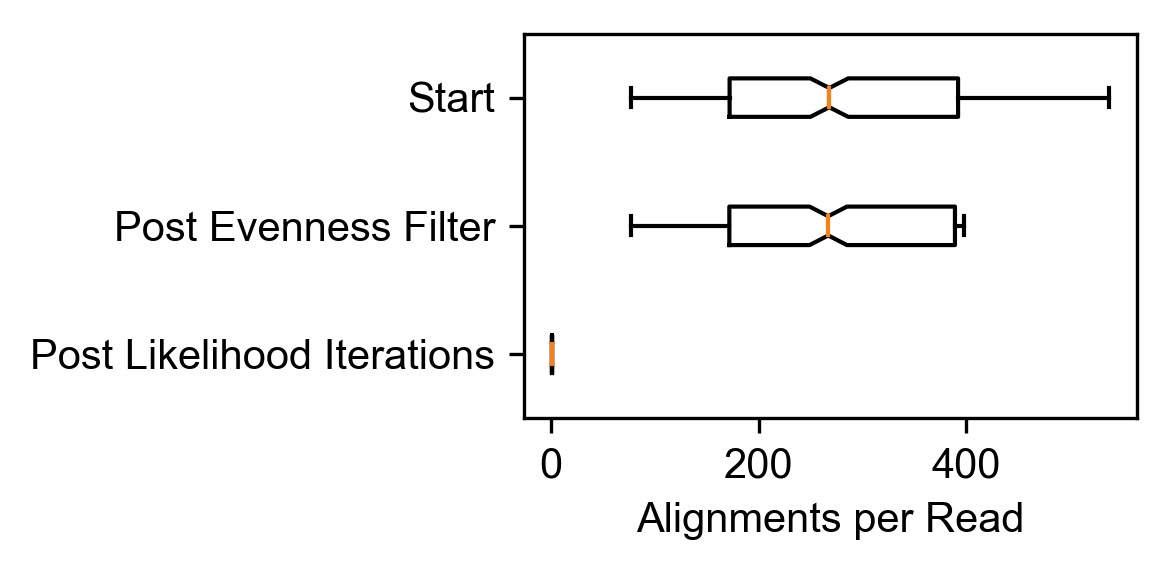

In [31]:
# Update our boxplot now we are past iterations
plt.clf()
plt.figure(figsize=(4,2), dpi=300)
plt.boxplot(
    [
        [len(likelihood_q_s[q]) for q in likelihood_q_s],
        subjects_per_query_ef.values,
        subjects_per_query.values,
    ], 
    labels=[
        'Post Likelihood Iterations',
        'Post Evenness Filter',
        'Start'
    ],
    vert=False,
    notch=True,
)
plt.xlabel('Alignments per Read')
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/AlnPerRead___postiterations.svg')
plt.show()

In [32]:
spq.head()

,Start,Evenness Filter,Iteration 1,Iteration 2,Iteration 3,Iteration 4,Iteration 5,Iteration 6,Iteration 7,Iteration 8,Iteration 9,Iteration 10
qseqid,,,,,,,,,,,,
NC_000913.3:102203-103183-1,289,289,245,233,193,144,71,13,7,1,1,1
NC_000913.3:102203-103183-10,268,268,243,232,186,149,74,13,7,1,1,1
NC_000913.3:102203-103183-100,416,326,244,232,194,143,74,13,7,1,1,1
NC_000913.3:102203-103183-101,274,272,243,232,193,140,71,13,7,1,1,1
NC_000913.3:102203-103183-102,265,265,242,232,188,136,68,13,7,1,1,1


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

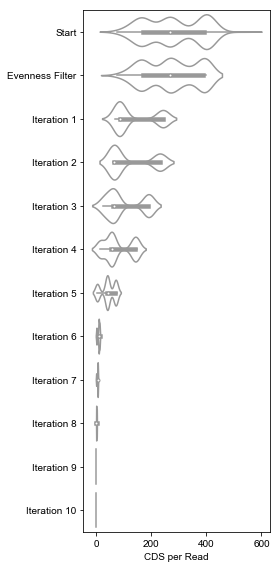

In [33]:
plt.clf()
plt.figure(figsize=(4,8), dpi=72)
ax = plt.gca()
sns.violinplot(
    data=spq.melt(),
    x='value',
    y='variable',
    ax=ax,
    scale='width',
    #inner=None
    color='white'
)

ax.set_ylabel("")
ax.set_xlabel('CDS per Read')
#ax.set_xlim([-10,600])

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/CDSPerRead___all_violin.svg', dpi=300)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

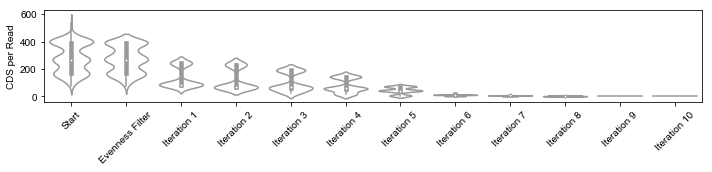

In [34]:
plt.clf()
plt.figure(figsize=(10,2.5), dpi=72)
ax = plt.gca()
sns.violinplot(
    data=spq.melt(),
    y='value',
    x='variable',
    ax=ax,
    scale='width',
    #inner=None
    color='white'
)

ax.set_xlabel("")
ax.set_ylabel('CDS per Read')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

plt.tight_layout()
if SAVE_FIGS:
    plt.savefig('figures/CDSPerRead___all_violin_h.svg', dpi=300)
plt.show()

In [35]:
query_remaining_ref = [(q,len(likelihood_q_s[q])) for q in likelihood_q_s]
query_remaining_ref.sort(key=lambda r: r[1])
print(query_remaining_ref[:5])
print(max([len(likelihood_q_s[q]) for q in likelihood_q_s]))

[('NC_000913.3:102203-103183-1', 1), ('NC_000913.3:102203-103183-10', 1), ('NC_000913.3:102203-103183-100', 1), ('NC_000913.3:102203-103183-101', 1), ('NC_000913.3:102203-103183-102', 1)]
1


In [36]:
# Repeat evenness filters:
s_passing_second_even_filter = set()
for s in coverage_s_q:
    s_cover = np.zeros(s_len[s], dtype='int')
    for q in coverage_s_q[s]:
        s_cover[coverage_s_q[s][q][0]-1:coverage_s_q[s][q][1]-1] += 1
    if (s_cover[18:-18].std() / s_cover[18:-18].mean()) <= 1.0:
        s_passing_second_even_filter.add(s)

len(s_passing_second_even_filter)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


3

In [37]:
s_passing_second_even_filter

{'UniRef100_P07862', 'UniRef100_P0A9A8', 'UniRef100_P25536'}

In [38]:
subj_true_positives

['UniRef100_P0A9A8', 'UniRef100_P25536', 'UniRef100_P07862']

In [39]:
# Victory!
s_passing_second_even_filter == set(subj_true_positives)

True